Original Data Shape: torch.Size([300, 3])


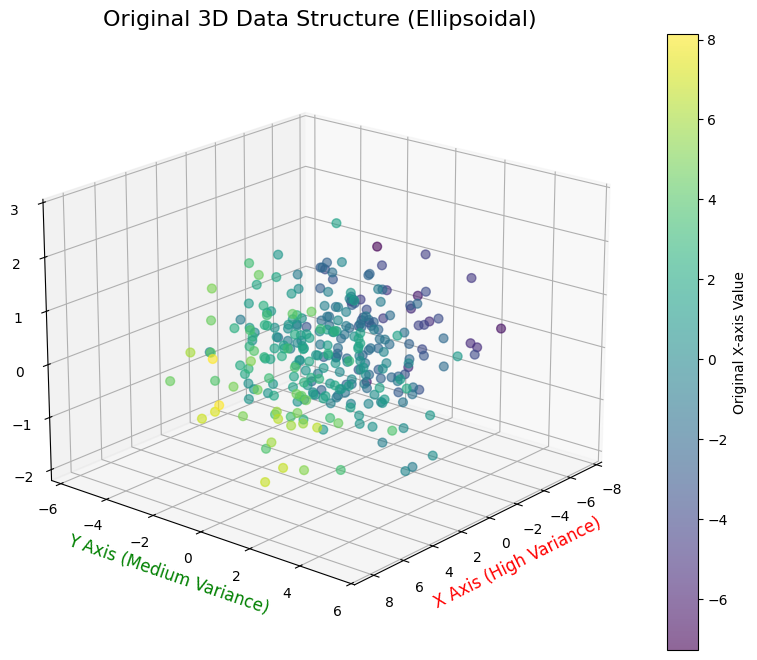

Projection Matrix (W) Shape: torch.Size([3, 2])
Reduced Data Shape: torch.Size([300, 2])


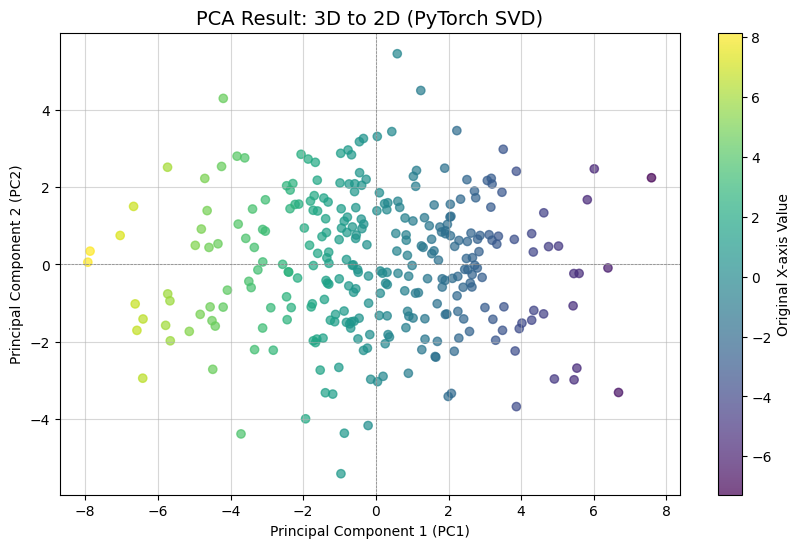


--- Explained Variance ---
Total Variance Explained by PC1 ~ PC2: 95.38%
PC1 Ratio: 69.30%
PC2 Ratio: 26.09%
PC3 Ratio: 4.62%


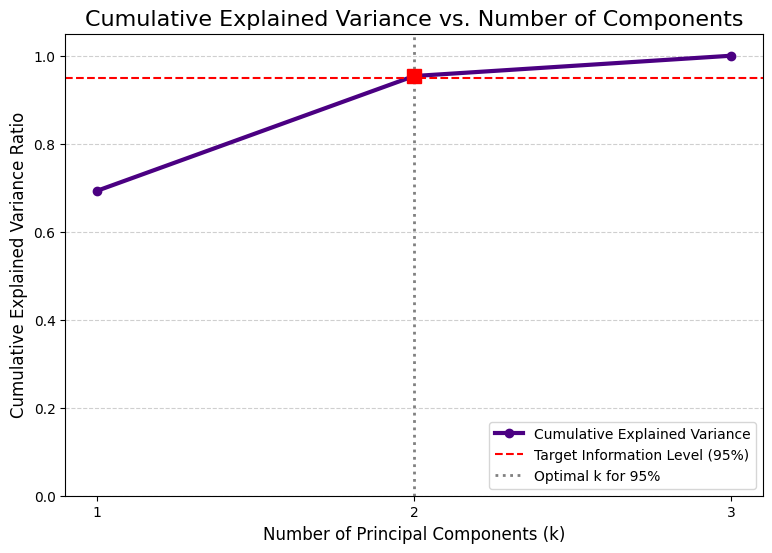


--- Reconstruction Verification ---
Original Data Shape (X): torch.Size([300, 3])
Reconstructed Data Shape (X_reconstructed): torch.Size([300, 3])
Reconstruction Loss (MSE): 0.1773


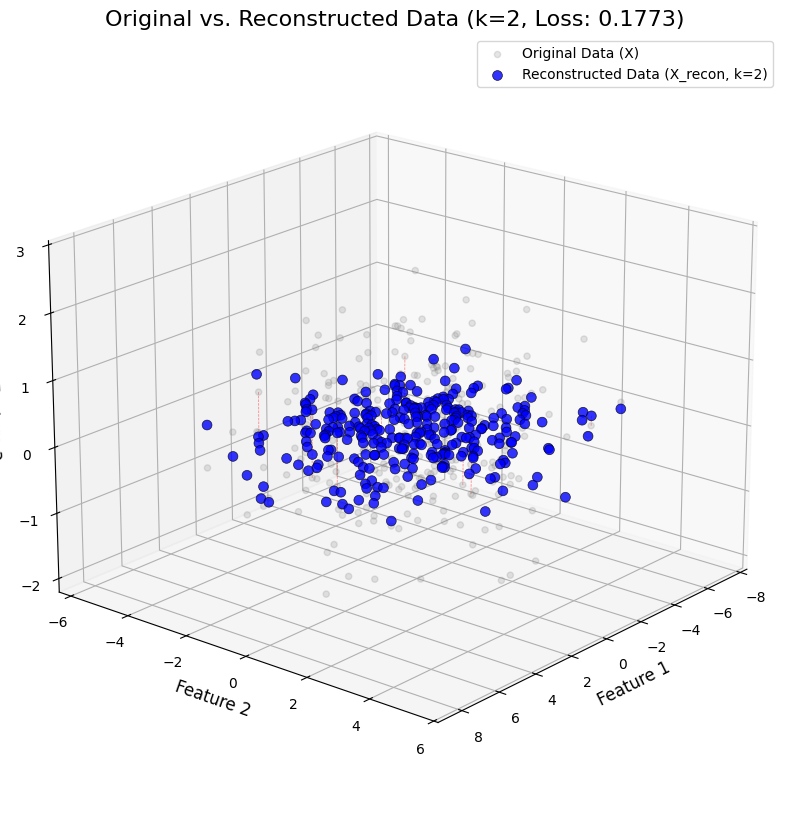

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.linalg import svd
from mpl_toolkits.mplot3d import Axes3D

# ============================================================
# 원본 데이터 만들기
# ============================================================
np.random.seed(42)
n_samples = 300
n_features = 3  # 3차원의 원본 데이터
n_components = 2  # 2차원으로 축소

# X축 방향으로 가장 긴 타원형 데이터
X_np = np.random.multivariate_normal([0, 0, 0], 
                                     [[10, 0, 0], [0, 3, 0], [0, 0, 0.5]], n_samples)

X = torch.tensor(X_np, dtype=torch.float32)
print(f"Original Data Shape: {X.shape}")  # 300 X 3


# ============================================================
# 원본 데이터 시각화
# ============================================================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], 
           s=40, # 포인트 크기
           alpha=0.6, 
           c=X[:, 0], 
           cmap='viridis')
ax.view_init(elev=20, azim=40)
ax.set_title("Original 3D Data Structure (Ellipsoidal)", fontsize=16)
ax.set_xlabel('X Axis (High Variance)', fontsize=12, color='red')
ax.set_ylabel('Y Axis (Medium Variance)', fontsize=12, color='green')
ax.set_zlabel('Z Axis (Low Variance)', fontsize=12, color='blue')
ax.grid(True)
plt.colorbar(scatter, label='Original X-axis Value')
plt.show()


# ============================================================
# PCA 구현
# ============================================================

# 1. 데이터 정규화: 모든 데이터의 평균을 0이 되도록 Centering
mean = torch.mean(X, dim=0)
X_centered = X - mean

# 2. SVD(Singular Value Decomposition); X = U * S * V^T
U, S, V = torch.linalg.svd(X_centered)

# 3. PC 선택
W = V[:n_components].T
print(f"Projection Matrix (W) Shape: {W.shape}")  # 3 X 2

# 4. Projection
Z = torch.matmul(X_centered, W)
print(f"Reduced Data Shape: {Z.shape}") # 300 X 2


# ============================================================
# 결과 시각화
# ============================================================
Z_np = Z.numpy()  # Z 텐서를 NumPy 배열로 변환

plt.figure(figsize=(10, 6))
scatter_proj = plt.scatter(Z_np[:, 0], Z_np[:, 1], alpha=0.7, c=X_np[:, 0], cmap='viridis') 
plt.title(f'PCA Result: {n_features}D to {n_components}D (PyTorch SVD)', fontsize=14)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(scatter_proj, label='Original X-axis Value')
plt.grid(True, alpha=0.5)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.show()


# ============================================================
# 분산 설명력 확인 (Explained Variance Ratio)
# ============================================================
# 특이값 S의 제곱이 곧 분산에 비례
total_variance = torch.sum(S**2)
explained_variance_ratio_all = (S**2) / total_variance
cumulative_variance = torch.cumsum(explained_variance_ratio_all, dim=0).numpy()

# 분산 설명력 출력
explained_variance_ratio_selected = explained_variance_ratio_all[:n_components]
print("\n--- Explained Variance ---")
print(f"Total Variance Explained by PC1 ~ PC{n_components}: {torch.sum(explained_variance_ratio_selected)*100:.2f}%")
for i in range(n_features):
    print(f"PC{i+1} Ratio: {explained_variance_ratio_all[i].item()*100:.2f}%")


# ============================================================
# 차원 수에 따른 누적 설명 분산
# ============================================================
pc_index = np.arange(1, n_features + 1)
target_information_level = 0.95 # 목표 보존 정보량 (95%)

plt.figure(figsize=(9, 6))

# 1. 누적 설명 분산 라인 플롯
plt.plot(pc_index, cumulative_variance, 
         color='indigo', marker='o', linestyle='-', linewidth=3, 
         label='Cumulative Explained Variance')

# 2. 목표 정보량 (95%) 수평선
plt.axhline(y=target_information_level, color='red', linestyle='--', linewidth=1.5, 
            label=f'Target Information Level ({target_information_level*100:.0f}%)')

# 3. 목표 정보량을 달성하는 지점 (PC2) 시각화
# 여기서는 PC2에서 95.38%로 목표를 달성함
optimal_k = 2 
plt.axvline(x=optimal_k, color='gray', linestyle=':', linewidth=2, 
            label=f'Optimal k for {target_information_level*100:.0f}%')
plt.plot(optimal_k, cumulative_variance[optimal_k-1], 's', color='red', markersize=10) # 달성 지점 표시

plt.title('Cumulative Explained Variance vs. Number of Components', fontsize=16)
plt.xlabel('Number of Principal Components (k)', fontsize=12)
plt.ylabel('Cumulative Explained Variance Ratio', fontsize=12)
plt.xticks(pc_index)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()


# ============================================================
# 역변환 (재구성)
# ============================================================
W_T = W.T # 2 x 3
X_reconstructed_centered = torch.matmul(Z, W_T) # 300 x 3

# 평균(mu)을 다시 더하여 최종 재구성 데이터 X_reconstructed 얻기
X_reconstructed = X_reconstructed_centered + mean

# 6. 재구성 손실 (MSE) 계산
# torch.nn.functional.mse_loss를 사용하거나 직접 계산 가능
reconstruction_loss = torch.mean((X - X_reconstructed)**2)

print(f"\n--- Reconstruction Verification ---")
print(f"Original Data Shape (X): {X.shape}")
print(f"Reconstructed Data Shape (X_reconstructed): {X_reconstructed.shape}")
print(f"Reconstruction Loss (MSE): {reconstruction_loss.item():.4f}")


# ============================================================
# 원본 vs. 재구성 데이터 시각화
# ============================================================
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 1. 원본 데이터 (옅은 회색으로 배경처럼 표시)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], 
           s=20, alpha=0.2, color='gray', label='Original Data (X)')

# 2. 재구성된 데이터 (파란색으로 명확히 표시)
scatter_recon = ax.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], X_reconstructed[:, 2], 
                           s=50, alpha=0.8, color='blue', edgecolor='k', linewidth=0.5,
                           label=f'Reconstructed Data (X_recon, k={n_components})')

# 3. 투영 오차 시각화 (원본과 재구성된 점 사이를 선으로 연결)
# 일부 샘플만 연결하여 시각적 복잡도를 낮춥니다.
for i in range(0, n_samples, 30):
    ax.plot([X[i, 0].item(), X_reconstructed[i, 0].item()],
            [X[i, 1].item(), X_reconstructed[i, 1].item()],
            [X[i, 2].item(), X_reconstructed[i, 2].item()],
            color='red', linestyle='--', linewidth=0.5, alpha=0.5)

ax.view_init(elev=20, azim=40)
ax.set_title(f"Original vs. Reconstructed Data (k={n_components}, Loss: {reconstruction_loss.item():.4f})", fontsize=16)
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.set_zlabel('Feature 3', fontsize=12)
ax.legend(loc='upper right')
plt.show()